In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import shutil
import warnings
import os
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
import tensorflow as tf
import random

In [2]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds()

In [3]:
warnings.filterwarnings('ignore')
shutil.rmtree('lstm_bayes_tuning')
%matplotlib inline

In [4]:
df = pd.read_excel("../datasets/Tesla_Stock.xlsx")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df[["Close"]]

df = df.iloc[-2000:]

train_size = int(len(df) * 0.8)
df_train_raw = df.iloc[:train_size]
df_test_raw = df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train_raw)
scaled_test = scaler.transform(df_test_raw)

df_train = pd.DataFrame(scaled_train, columns=df.columns, index=df_train_raw.index)
df_test = pd.DataFrame(scaled_test, columns=df.columns, index=df_test_raw.index)

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 1600
Testing data size: 400


In [5]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [6]:
X_train, y_train = create_sequences(scaled_train)
X_test, y_test = create_sequences(scaled_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [7]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=hp.Int('lstm_units_1', 32, 128, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('lstm_units_2', 32, 128, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(units=1))
    
    optimizer = Adam(learning_rate=hp.Choice('lr', values=[1e-4, 5e-4, 1e-3]))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train_final, y_train_final = X_train[:-val_size], y_train[:-val_size]

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='lstm_bayes_tuning',
    overwrite=True
)

tuner.search(
    X_train_final, y_train_final,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=0
)

In [10]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hp)

best_model.compile(optimizer='adam', loss='mean_squared_error')

history = best_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stop],
    verbose=0
)

In [11]:
train_pred = best_model.predict(X_train)
train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
print(f"Train RMSE: {train_rmse:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Train RMSE: 7.2548


In [12]:
pred_path = "predictions/Stock_LSTM_train.npy"
os.makedirs("predictions", exist_ok = True)
np.save(pred_path, train_pred_inv)

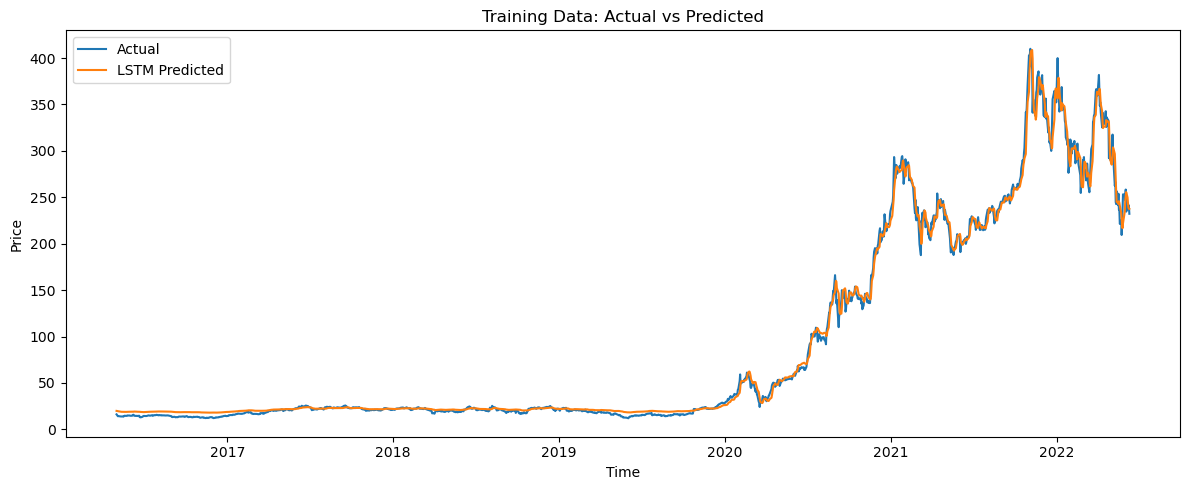

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(df_train_raw.index[-len(train_pred_inv):], y_train_inv, label='Actual')
plt.plot(df_train_raw.index[-len(train_pred_inv):], train_pred_inv, label='LSTM Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
test_pred = best_model.predict(X_test)
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Test RMSE: {test_rmse:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE: 9.2991


In [15]:
dataset_name = "Stock"
rmse_file = "RMSE_LSTM.json"

try:
    with open(rmse_file, "r") as f:
        rmse_data = json.load(f)
except FileNotFoundError:
    rmse_data = {}

rmse_data[dataset_name] = round(test_rmse, 2)

with open(rmse_file, "w") as f:
    json.dump(rmse_data, f, indent = 4)

In [16]:
pred_path = "predictions/Stock_LSTM_test.npy"
os.makedirs("predictions", exist_ok = True)
np.save(pred_path, test_pred_inv)

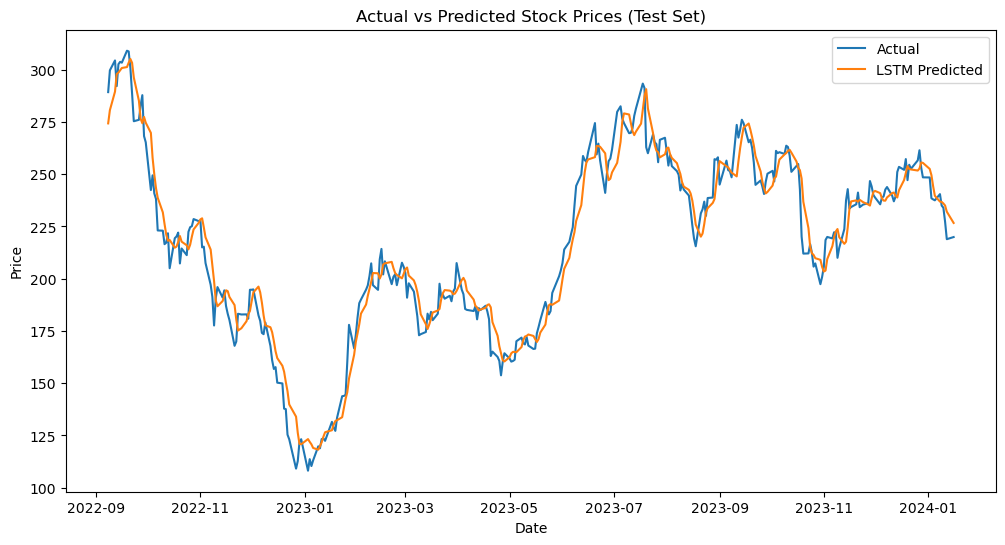

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(df_test_raw.index[-len(test_pred_inv):], y_test_inv, label='Actual')
plt.plot(df_test_raw.index[-len(test_pred_inv):], test_pred_inv, label='LSTM Predicted')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()